In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import acessos as ac
import funcionalidade as fc
import re
from pylift import TransformedOutcome
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Obtenção de dados - fonte da tabela na pasta sql

In [2]:
query = """
  
select * from customer_sandbox_zone.dados_estudo_mgm_flavia

"""

df = ac.df_athena('flavia-costa', query)

In [3]:
len(df)

1035884

In [4]:
df.dtypes

cpf                          object
tempo_aprovacao             float64
tempo_relacionamento        float64
ganho_limite                float64
ds_risk_type                 object
gender                       object
nr_declared_income          float64
ds_region                    object
flag_autonomo                 int64
max_limite                  float64
max_qtd_if                    int64
avg_utilizado_interno       float64
sum_utilizado_interno       float64
avg_utilizado_mercado       float64
sum_utilizado_mercado       float64
nr_chaves_importantes       float64
nr_antecipacao_fatura       float64
nr_bolso_ativo              float64
nr_trans_mov_conta          float64
nr_purchases_virtual        float64
avg_vl_total_spending       float64
nr_purchases_online         float64
nr_acessos                  float64
pc_acessos_lojawill         float64
flag_mgm                    float64
dias_atraso                   int64
ordem                         int64
flag_limite_insuficiente    

In [5]:
df.head()

,cpf,tempo_aprovacao,tempo_relacionamento,ganho_limite,ds_risk_type,gender,nr_declared_income,ds_region,flag_autonomo,max_limite,...,nr_purchases_virtual,avg_vl_total_spending,nr_purchases_online,nr_acessos,pc_acessos_lojawill,flag_mgm,dias_atraso,ordem,flag_limite_insuficiente,share_of_wallet
0,08826281432,3.0,350.0,340.0,3. Medio Risco,MALE,1733.0,Nordeste,0,1200.0,...,0.0,1976.163333,4.0,388.0,0.005155,1.0,0,29672,1,0.457809
1,27527276827,4.0,351.0,500.0,4. Baixo Risco,FEMALE,2200.0,Nordeste,0,2700.0,...,0.0,926.520000,1.0,135.0,0.000000,1.0,0,29673,1,0.258186
2,12899652770,1.0,336.0,140.0,2. Alto Risco,FEMALE,800.0,Sudeste,1,500.0,...,0.0,617.965455,10.0,450.0,0.013333,1.0,0,29674,1,0.435081
3,42358143898,2.0,334.0,1840.0,3. Medio Risco,FEMALE,3500.0,Sudeste,0,2200.0,...,9.0,2316.790000,24.0,363.0,0.000000,1.0,0,29675,1,0.332347
4,15264522600,2.0,301.0,400.0,4. Baixo Risco,MALE,4000.0,Sudeste,1,1500.0,...,4.0,726.062222,35.0,150.0,0.006667,1.0,0,29676,1,0.192833


In [6]:
df.isnull().sum()

cpf                              0
tempo_aprovacao               3171
tempo_relacionamento          3171
ganho_limite                120421
ds_risk_type                     0
gender                        9190
nr_declared_income               0
ds_region                       12
flag_autonomo                    0
max_limite                       0
max_qtd_if                       0
avg_utilizado_interno        97612
sum_utilizado_interno        97612
avg_utilizado_mercado        97612
sum_utilizado_mercado        97612
nr_chaves_importantes       375425
nr_antecipacao_fatura       375425
nr_bolso_ativo              375425
nr_trans_mov_conta          375425
nr_purchases_virtual        122126
avg_vl_total_spending       122126
nr_purchases_online         122126
nr_acessos                  500000
pc_acessos_lojawill         500000
flag_mgm                    500000
dias_atraso                      0
ordem                            0
flag_limite_insuficiente         0
share_of_wallet     

### Definindo tipos de var e lidando com missings

In [7]:
#variáveis para recodificar como zero
df['share_of_wallet'] = df['share_of_wallet'].fillna(0.0)
df['ganho_limite'] = df['ganho_limite'].fillna(0.0)

df['nr_purchases_online'] = df['nr_purchases_online'].fillna(0.0)
df['nr_acessos'] = df['nr_acessos'].fillna(0.0)
df['pc_acessos_lojawill'] = df['pc_acessos_lojawill'].fillna(0.0)
df['nr_chaves_importantes'] = df['nr_chaves_importantes'].fillna(0.0)

In [8]:
id_columns = ['cpf', 'ordem']
cat_columns = df.drop(id_columns, axis = 1).select_dtypes('object').columns
num_columns = df.drop(id_columns, axis = 1).select_dtypes(exclude=['object']).columns

In [9]:
df.drop(id_columns, axis=1).describe()

,tempo_aprovacao,tempo_relacionamento,ganho_limite,nr_declared_income,flag_autonomo,max_limite,max_qtd_if,avg_utilizado_interno,sum_utilizado_interno,avg_utilizado_mercado,...,nr_trans_mov_conta,nr_purchases_virtual,avg_vl_total_spending,nr_purchases_online,nr_acessos,pc_acessos_lojawill,flag_mgm,dias_atraso,flag_limite_insuficiente,share_of_wallet
count,1.032713e+06,1.032713e+06,1.035884e+06,1.035884e+06,1.035884e+06,1.035884e+06,1.035884e+06,938272.000000,9.382720e+05,9.382720e+05,...,660459.000000,913758.000000,913758.000000,1.035884e+06,1.035884e+06,1.035884e+06,535884.000000,1.035884e+06,1.035884e+06,1.035884e+06
mean,1.467497e+01,7.992940e+02,1.203488e+03,5.204998e+06,2.623421e-01,3.047943e+03,4.566073e+00,2085.512372,2.946778e+04,9.958559e+03,...,56.714933,4.228206,1084.588711,4.490622e+01,7.471051e+01,7.358464e-03,0.066962,6.994606e-02,6.988012e-01,2.956909e-01
std,5.375132e+01,6.322262e+02,2.638978e+03,2.768569e+09,4.399079e-01,3.546639e+03,3.471403e+00,3425.255387,6.928761e+04,5.712937e+04,...,207.358497,27.571874,1507.814411,1.211845e+02,1.950965e+02,3.373559e-02,0.249957,3.215492e-01,4.587791e-01,2.646219e-01
min,-3.000000e+01,1.000000e+00,-9.900000e+03,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,-68.136667,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.170000e+02,0.000000e+00,1.000000e-02,0.000000e+00,9.000000e+02,2.000000e+00,403.917500,2.260800e+03,9.976875e+02,...,6.000000,0.000000,407.580000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.418930e-02
50%,2.000000e+00,6.640000e+02,0.000000e+00,1.500000e+03,0.000000e+00,1.770000e+03,4.000000e+00,1136.845000,1.158592e+04,2.706268e+03,...,16.000000,0.000000,702.095606,8.000000e+00,3.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,2.567087e-01
75%,6.000000e+00,1.345000e+03,1.000000e+03,3.000000e+03,1.000000e+00,3.500000e+03,6.000000e+00,2470.245000,3.133936e+04,7.248609e+03,...,45.000000,0.000000,1238.191250,3.900000e+01,8.600000e+01,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,4.923781e-01
max,1.156000e+03,2.309000e+03,9.830000e+04,2.220000e+12,1.000000e+00,9.900000e+04,4.100000e+01,221054.240000,6.364549e+06,2.470661e+07,...,57385.000000,5150.000000,117023.200000,1.203200e+04,1.675200e+04,1.000000e+00,1.000000,2.000000e+00,1.000000e+00,1.000000e+00


In [10]:
for column in df.columns:
  if df[column].dtype == 'object':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype == 'string':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype != 'object':
    df[column].fillna(df[column].median(), inplace = True)

In [11]:
df.isnull().sum()

cpf                         0
tempo_aprovacao             0
tempo_relacionamento        0
ganho_limite                0
ds_risk_type                0
gender                      0
nr_declared_income          0
ds_region                   0
flag_autonomo               0
max_limite                  0
max_qtd_if                  0
avg_utilizado_interno       0
sum_utilizado_interno       0
avg_utilizado_mercado       0
sum_utilizado_mercado       0
nr_chaves_importantes       0
nr_antecipacao_fatura       0
nr_bolso_ativo              0
nr_trans_mov_conta          0
nr_purchases_virtual        0
avg_vl_total_spending       0
nr_purchases_online         0
nr_acessos                  0
pc_acessos_lojawill         0
flag_mgm                    0
dias_atraso                 0
ordem                       0
flag_limite_insuficiente    0
share_of_wallet             0
dtype: int64

In [12]:
df['flag_mgm'].value_counts()

0.0    1000000
1.0      35884
Name: flag_mgm, dtype: int64

In [1]:
35884 / (1000000 + 35884)

0.034640944352842595

### Correlações

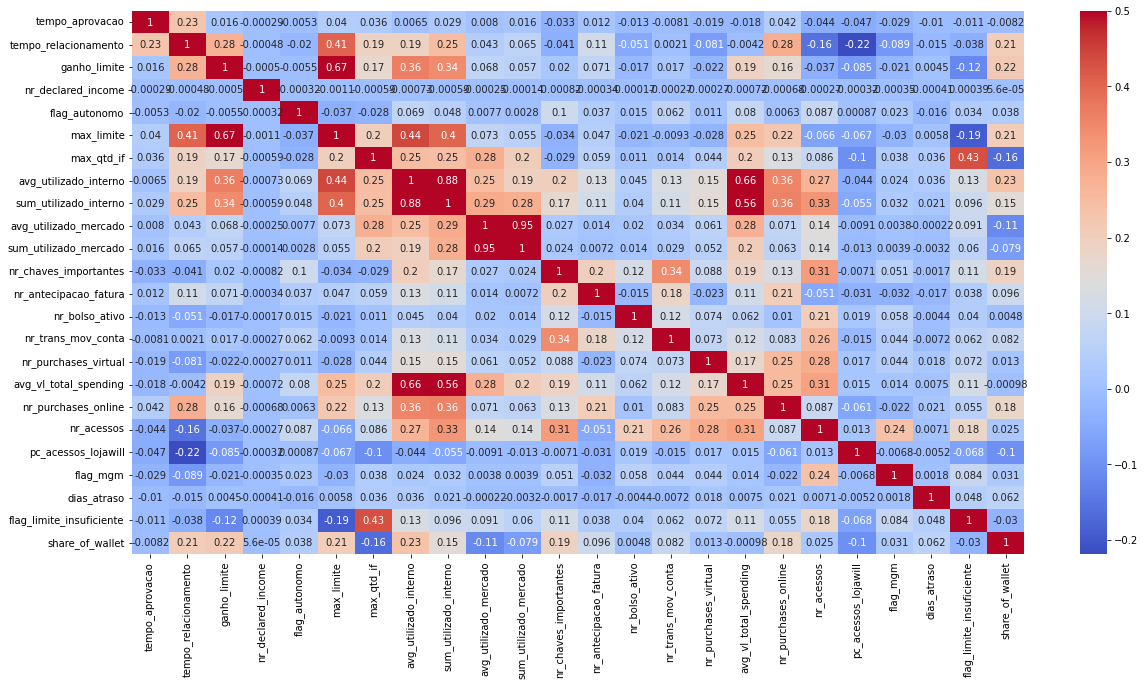

In [13]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(df.drop(id_columns, axis=1).corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

In [14]:
cat_columns

Index(['ds_risk_type', 'gender', 'ds_region'], dtype='object')

### Distribuição da var resposta

In [15]:
df['flag_autonomo'].value_counts()


0    764128
1    271756
Name: flag_autonomo, dtype: int64

## Início modelagem

In [16]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing as pr
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.decomposition import PCA
from sklearn import tree

In [17]:
df.columns

Index(['cpf', 'tempo_aprovacao', 'tempo_relacionamento', 'ganho_limite',
       'ds_risk_type', 'gender', 'nr_declared_income', 'ds_region',
       'flag_autonomo', 'max_limite', 'max_qtd_if', 'avg_utilizado_interno',
       'sum_utilizado_interno', 'avg_utilizado_mercado',
       'sum_utilizado_mercado', 'nr_chaves_importantes',
       'nr_antecipacao_fatura', 'nr_bolso_ativo', 'nr_trans_mov_conta',
       'nr_purchases_virtual', 'avg_vl_total_spending', 'nr_purchases_online',
       'nr_acessos', 'pc_acessos_lojawill', 'flag_mgm', 'dias_atraso', 'ordem',
       'flag_limite_insuficiente', 'share_of_wallet'],
      dtype='object')

In [18]:
#tempo_relacionamento, nr_acessos, share of wallet, declared income,  purchases on line, max_limite, Avg Spending, trans mov conta, limite insuficiente, ganho limite, percentual loja will
preditores = ['tempo_aprovacao', 'flag_autonomo', 'dias_atraso', 'tempo_relacionamento', 'avg_vl_total_spending', 'nr_declared_income', 'ganho_limite', 'flag_limite_insuficiente', 'share_of_wallet', 'nr_trans_mov_conta', 'nr_purchases_online']
target = ['flag_mgm']

In [19]:
#df_model = pd.get_dummies(df, columns=cat_columns)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(df[preditores]
                                                    , df[target]
                                                    , random_state=42, test_size=0.20)

In [21]:
x_train = x_train.replace([np.inf, -np.inf], 0)
x_test = x_test.replace([np.inf, -np.inf], 0)

In [22]:
#balanceamento
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 42)
x_train, y_train = ros.fit_resample(x_train, y_train)

In [23]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42) #early_stopping_rounds=2

In [24]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [25]:
scores = cross_val_score(xgb_model, x_train, y_train, scoring='f1_macro' , cv = StratifiedKFold(n_splits=5))
print("%0.2f F1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.89 F1 with a standard deviation of 0.00


In [33]:
scores = cross_val_score(xgb_model, x_test, y_test, scoring='f1_macro' , cv = StratifiedKFold(n_splits=5))
print("%0.2f F1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.50 F1 with a standard deviation of 0.00


<Figure size 1440x1440 with 0 Axes>

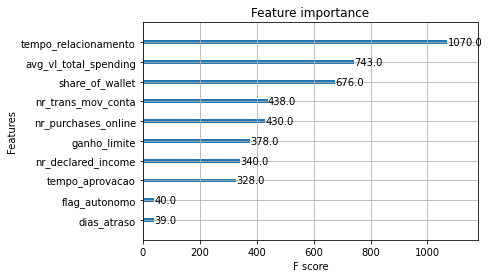

In [26]:
plt.figure(figsize=(20,20))
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

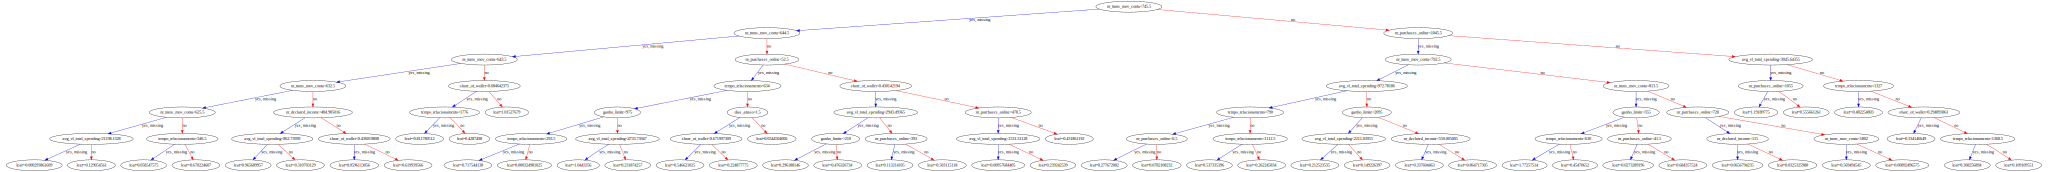

In [27]:
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)

In [28]:
y_predicted = xgb_model.predict(x_test)

In [29]:
clf_results = pd.DataFrame()
clf_results['predito'] = y_predicted
clf_results['real'] = y_test.values

df_confusion = pd.crosstab(clf_results.real, clf_results.predito)
df_confusion.head()

predito,0,1
real,,
0.0,167402,32612
1.0,608,6555


In [30]:
cont = len(y_test)
#falso negativo e positivo
fp = df_confusion.iloc[0,1]
fn = df_confusion.iloc[1,0]
#verdadeiro (true) positivo e negativo
tp = df_confusion.iloc[1,1]
tn = df_confusion.iloc[0,0]
#recall - taxa de captura de positivos
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f" F1: {f1}")
print(f" Recall: {recall}")
print(f" Precision: {precision}")

auroc = metrics.roc_auc_score(y_test, y_predicted).round(5)
accuracy = metrics.accuracy_score(y_test, y_predicted).round(5)
print("AUROC: " + str(auroc) + " e ACCURACY: " + str(accuracy))

 F1: 0.2829699978415713
 Recall: 0.9151193633952255
 Precision: 0.16736027778486992
AUROC: 0.87604 e ACCURACY: 0.83965


In [31]:
#Matriz 
y_predicted_clf_proba = xgb_model.predict_proba(x_test)[:, 1]
clf_results['Probabilidade'] = y_predicted_clf_proba
clf_results['fx_score'] = np.round(clf_results['Probabilidade'], 1)
clf_results['cpf'] =  1

clf_results_agg = clf_results.groupby('fx_score').agg({'real': ['count', 'sum']})
clf_results_agg.columns = clf_results_agg.columns.droplevel(0)
clf_results_agg['taxa_evento'] = clf_results_agg['sum'] / clf_results_agg['count']

In [32]:
clf_results_agg

,count,sum,taxa_evento
fx_score,,,
0.0,123032,64.0,0.000520
0.1,25614,117.0,0.004568
0.2,10044,124.0,0.012346
0.3,4638,123.0,0.026520
0.4,3271,118.0,0.036075
0.5,2743,147.0,0.053591
0.6,2648,191.0,0.072130
0.7,4398,394.0,0.089586
0.8,13468,1916.0,0.142263


Três formas de obter as regras:

- Buscar os nodes da arvore
- Max e Min ou Distribuição das variaveis principais por faixa de propensão
- Função de combinação

In [37]:
df_analise = x_test.copy().join(y_test)
df_analise['probabilidade'] = xgb_model.predict_proba(x_test)[:, 1]
df_analise

,tempo_aprovacao,flag_autonomo,dias_atraso,tempo_relacionamento,avg_vl_total_spending,nr_declared_income,ganho_limite,flag_limite_insuficiente,share_of_wallet,nr_trans_mov_conta,nr_purchases_online,flag_mgm,probabilidade
748739,6.0,0,0,377.0,433.835000,6000.00,250.0,1,0.061086,4.0,4.0,0.0,0.747331
337355,3.0,0,0,1409.0,842.550000,0.01,1500.0,1,0.059390,22.0,194.0,0.0,0.064572
32063,2.0,0,0,862.0,967.586207,1500.00,1400.0,0,0.870386,16.0,46.0,0.0,0.002621
952620,6.0,0,0,594.0,769.700000,2500.00,750.0,1,0.532121,36.0,15.0,0.0,0.875507
731885,0.0,0,2,97.0,1292.000000,3500.00,0.0,1,0.282982,11.0,4.0,0.0,0.000065
...,...,...,...,...,...,...,...,...,...,...,...,...,...
327230,5.0,1,0,2099.0,1582.676957,0.01,0.0,0,0.883498,75.0,215.0,0.0,0.000582
658835,1.0,0,0,225.0,307.085000,2000.00,0.0,1,0.075462,16.0,2.0,0.0,0.000051
602833,4.0,0,0,800.0,1181.056500,4000.00,0.0,1,0.261695,7.0,26.0,0.0,0.173714
844628,0.0,0,0,106.0,975.605000,2500.00,0.0,1,0.485272,16.0,7.0,0.0,0.000059


In [38]:
df_analise['faixa_propensao'] = np.where(df_analise['probabilidade'] < 0.2, '0. Grupo com propensão inf a 1%',
                                np.where(df_analise['probabilidade'] < 0.4, '1. Grupo com propensão inf a 3%',
                                np.where(df_analise['probabilidade'] < 0.7, '2. Grupo com propensão inf a 8%',
                                np.where(df_analise['probabilidade'] < 0.9, '3. Grupo com propensão entre 8-14%', '4. Grupo com propensão acima de 15%'))))

df_analise['faixa_propensao'].value_counts()

0. Grupo com propensão inf a 1%        154814
3. Grupo com propensão entre 8-14%      27590
1. Grupo com propensão inf a 3%         10279
2. Grupo com propensão inf a 8%          8638
4. Grupo com propensão acima de 15%      5856
Name: faixa_propensao, dtype: int64

In [39]:
df_analise[['faixa_propensao', 'flag_mgm']].groupby('faixa_propensao').mean()

,flag_mgm
faixa_propensao,
0. Grupo com propensão inf a 1%,0.001576
1. Grupo com propensão inf a 3%,0.024419
2. Grupo com propensão inf a 8%,0.060662
3. Grupo com propensão entre 8-14%,0.160855
4. Grupo com propensão acima de 15%,0.291325


In [40]:
def discretiza(df, drop_col):
    num_columns = df.drop(drop_col, axis = 1).select_dtypes(exclude=['object']).columns
    stats = df.drop(drop_col, axis=1).describe()
    for i in num_columns:
        p75 = stats.iloc[6][i]
        p25 = stats.iloc[4][i]
        p50 = stats.iloc[5][i]
        
        df['aux'] = np.where((df[i] <= p25), "A - " + i,
                    np.where((df[i] > p25) & (df[i] <= p50), "B - " + i,
                    np.where((df[i] > p50) & (df[i] <= p75), "C - " + i, "D - " + i)))
  
        df = df.rename(columns = {'aux':i+"_fx"})

    return df

In [41]:
df_comb = discretiza(df_analise.copy(), ['flag_mgm', 'probabilidade'])

In [43]:
df_comb.columns

Index(['tempo_aprovacao', 'flag_autonomo', 'dias_atraso',
       'tempo_relacionamento', 'avg_vl_total_spending', 'nr_declared_income',
       'ganho_limite', 'flag_limite_insuficiente', 'share_of_wallet',
       'nr_trans_mov_conta', 'nr_purchases_online', 'flag_mgm',
       'probabilidade', 'faixa_propensao', 'tempo_aprovacao_fx',
       'flag_autonomo_fx', 'dias_atraso_fx', 'tempo_relacionamento_fx',
       'avg_vl_total_spending_fx', 'nr_declared_income_fx', 'ganho_limite_fx',
       'flag_limite_insuficiente_fx', 'share_of_wallet_fx',
       'nr_trans_mov_conta_fx', 'nr_purchases_online_fx'],
      dtype='object')

In [44]:
df_comb['cont'] = 1

In [45]:
colunas_analise = ['tempo_aprovacao_fx',
       'flag_autonomo_fx', 'dias_atraso_fx', 'tempo_relacionamento_fx',
       'avg_vl_total_spending_fx', 'nr_declared_income_fx', 'ganho_limite_fx',
       'flag_limite_insuficiente_fx', 'share_of_wallet_fx',
       'nr_trans_mov_conta_fx', 'nr_purchases_online_fx']

report_combinacoes = fc.report_perfil_grupos(df_comb, 'faixa_propensao', 'cont', 0.05, 50, colunas_analise).query('diferenca > 0')

/home/flavia.costa/projetos/diretorio_trabalho/Segmentacao_mgm/funcionalidade.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna_contagem] = df[coluna_contagem].astype('int')


In [48]:
report_combinacoes.to_csv('report_combinacoes.csv')

In [46]:
print(report_combinacoes.query('faixa_propensao == "3. Grupo com propensão entre 8-14%"')['segmento'].unique())

['- C tempo_aprovacao A flag_autonomo dias_atraso B tempo_relacionamento avg_vl_total_spending nr_declared_income D ganho_limite flag_limite_insuficiente'
 '- C tempo_aprovacao A flag_autonomo dias_atraso B tempo_relacionamento avg_vl_total_spending nr_declared_income D ganho_limite'
 '- A tempo_aprovacao flag_autonomo dias_atraso B tempo_relacionamento avg_vl_total_spending nr_declared_income D ganho_limite'
 '- A tempo_aprovacao flag_autonomo dias_atraso B tempo_relacionamento avg_vl_total_spending C nr_declared_income D ganho_limite'
 '- C tempo_aprovacao A flag_autonomo dias_atraso B tempo_relacionamento avg_vl_total_spending D nr_declared_income ganho_limite flag_limite_insuficiente share_of_wallet'
 '- B tempo_aprovacao A flag_autonomo dias_atraso tempo_relacionamento C avg_vl_total_spending D nr_declared_income ganho_limite'
 '- B tempo_aprovacao A flag_autonomo dias_atraso tempo_relacionamento avg_vl_total_spending C nr_declared_income D ganho_limite flag_limite_insuficiente'
 

In [49]:
print(report_combinacoes.query('faixa_propensao == "4. Grupo com propensão acima de 15%"')['segmento'].unique())

['- B tempo_aprovacao C flag_autonomo A dias_atraso tempo_relacionamento D avg_vl_total_spending nr_declared_income ganho_limite flag_limite_insuficiente share_of_wallet'
 '- C tempo_aprovacao flag_autonomo A dias_atraso B tempo_relacionamento D avg_vl_total_spending nr_declared_income ganho_limite flag_limite_insuficiente share_of_wallet'
 '- A tempo_aprovacao C flag_autonomo dias_atraso B tempo_relacionamento avg_vl_total_spending nr_declared_income ganho_limite flag_limite_insuficiente share_of_wallet'
 '- C tempo_aprovacao A flag_autonomo dias_atraso B tempo_relacionamento D avg_vl_total_spending nr_declared_income ganho_limite flag_limite_insuficiente share_of_wallet nr_trans_mov_conta'
 '- B tempo_aprovacao C flag_autonomo A dias_atraso tempo_relacionamento D avg_vl_total_spending nr_declared_income ganho_limite flag_limite_insuficiente'
 '- B tempo_aprovacao C flag_autonomo A dias_atraso tempo_relacionamento D avg_vl_total_spending nr_declared_income ganho_limite'
 '- A tempo_ap